"Function constant is: 0.0038925992605490915"

"Maximum voltage is: 0.2343858034463789"

"Minimum voltage is: -0.12230695201277106"

"Voltage difference is: 0.35669275545914997"

┌ Warning: attempting to remove probably stale pidfile
│   path = /home/puripat/.jlassetregistry.lock
└ @ Pidfile /home/puripat/.julia/packages/Pidfile/DDu3M/src/Pidfile.jl:260


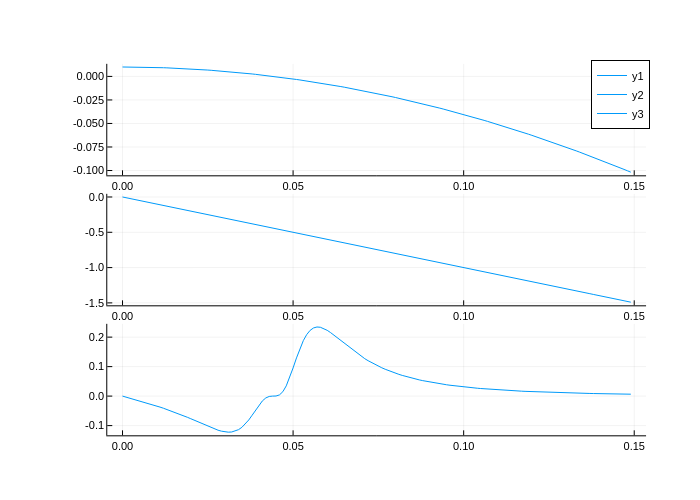

In [1]:
using Plots; plotlyjs()
using LsqFit

global initZ = 0.01
global initVelo = 0
global magneticPermeability = 1.256 * 10e-6
global solenoidLoopCount = 164
global solenoidRadius = 0.005
global solenoidLength = 2*π*solenoidRadius*solenoidLoopCount
global solenoidResistance = 1.72 * 10e-8 * solenoidLength
global gravitationalConst = 10
global copperDensity = 8850
global solenoidMass = 0.018#solenoidLength * π * solenoidRadius^2 * copperDensity
global magneticMoment = 0.4
global functionConst = (magneticMoment * magneticPermeability / 2)^2 * (12 * solenoidLoopCount * solenoidRadius) / (solenoidResistance * solenoidMass)
F(z) = functionConst * (2*z^3/(solenoidRadius^2 + z^2)^5 + z/(solenoidRadius^2 + z^2)^4)
display("Function constant is: $functionConst")

global simTime = 0.15
global timeStep = 0.001
global timeInterval = collect(0:timeStep:simTime)
global timeIndex = Int32.(collect(1:simTime/timeStep))

# Differential equation: z'' = F(z)z' + g
accelHistory = Float64.([])
posHistory = Float64.([initZ])
veloHistory = Float64.([initVelo])
for i in timeIndexV
	accel = - gravitationalConst #+ F(posHistory[i]) * veloHistory[i]
	nextVelo = veloHistory[i] + accel * timeStep
	push!(accelHistory, accel)
	push!(veloHistory, nextVelo)

	nextPos = posHistory[i] + veloHistory[i + 1] * timeStep
	push!(posHistory, nextPos)
end
accelHistory = Float64.(accelHistory)

# Finding the voltage

voltage(z, v) = - solenoidLoopCount * magneticPermeability * solenoidMass * z / 2 * v * (1/(solenoidRadius + z^2)^(3/2) - 3*z^2/(solenoidRadius^2 + z^2)^(5/2))
voltageHistory = [voltage(posHistory[i], veloHistory[i]) for i in 1:Int64(simTime/timeStep)]
minVoltage = minimum(voltageHistory)
maxVoltage = maximum(voltageHistory)
difVoltage = maxVoltage - minVoltage
display("Maximum voltage is: $maxVoltage")
display("Minimum voltage is: $minVoltage")
display("Voltage difference is: $difVoltage")

pop!(posHistory)
pop!(veloHistory)
pop!(timeInterval)
# plot(timeInterval, [posHistory veloHistory accelHistory voltageHistory], layout = (4, 1))
plot(timeInterval, [posHistory veloHistory voltageHistory], layout = (3, 1))

In [13]:
using CUDA

function simVoltageEuler(initZ, gravitationalConst)
	posHistory = Float64.([initZ])
	veloHistory = Float64.([0.0])
	accel = - gravitationalConst
	for i in timeIndex #accel = - gravitationalConst + F(posHistory[i]) * veloHistory[i]
		nextVelo = veloHistory[i] + accel * timeStep
		push!(veloHistory, nextVelo)

		nextPos = posHistory[i] + veloHistory[i + 1] * timeStep
		push!(posHistory, nextPos)
	end
	minVoltage, maxVoltage = extrema(voltage.(posHistory, veloHistory))
	return abs(maxVoltage - minVoltage)
end

posGen(initZ, gravitationalConst, t) = initZ - 1/2*gravitationalConst*t

function analyticalVoltage(initZ, gravitationalConst)
	
end

simVoltage(0, 10)

0.15061562484292743

In [2]:
gRange = collect(0:0.1:20)
heightRange = collect(1:1:10)
voltg = [] 
for initHeight in heightRange
	for gravitationalConst in gRange
		accelHistory = Float64.([])
		posHistory = Float64.([initHeight])
		veloHistory = Float64.([0])
		for i in timeIndex
			accel = - gravitationalConst #+ F(posHistory[i]) * veloHistory[i]
			nextVelo = veloHistory[i] + accel * timeStep
			push!(accelHistory, accel)
			push!(veloHistory, nextVelo)

			nextPos = posHistory[i] + veloHistory[i + 1] * timeStep
			push!(posHistory, nextPos)
		end
		voltageHistory = [voltage(posHistory[i], veloHistory[i]) for i in 1:Int64(simTime/timeStep)]
		minVoltage = minimum(voltageHistory)
		maxVoltage = maximum(voltageHistory)
		difVoltage = maxVoltage - minVoltage
		push!(voltg, difVoltage)
	end
end